In [1]:
%pip install ccxt yfinance seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import ccxt
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from utils import (
    TRAIN_TARGETS_PARQUET_FILE_PATH,
    OHLCV_FILE_PATH,
    TRAIN_START_DATE,
    CURRENT_DATE,
    SAMPLE_SYMBOLS,
    human_readable_format
)

TRAIN_START_DATE updated to: 2020-06-01, TRAIN_END_DATE updated to: 2024-07-05


In [3]:
train_df = pd.read_parquet(TRAIN_TARGETS_PARQUET_FILE_PATH)

In [4]:
# Initialize the ccxt binance client
exchange = ccxt.binance()

# Fetch historical data from Binance
def fetch_historical_data_binance(symbol, start_date, end_date):
    try:
        since = exchange.parse8601(start_date + 'T00:00:00Z')
        until = exchange.parse8601(end_date + 'T00:00:00Z')

        # Fetch daily OHLCV data
        ohlcv = exchange.fetch_ohlcv(symbol, '1d', since, until)
        
        # Convert to DataFrame
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['date'] = pd.to_datetime(df['timestamp'], unit='ms').dt.date
        if symbol == 'BTC': 
            print(df)
        return df[['date', 'open', 'high', 'low', 'close', 'volume']]
    except Exception as e:
        #print(f"Error fetching data for {symbol} from {start_date} to {end_date}: {e}")
        return None

# Fetch historical data from Yahoo Finance
def fetch_historical_data_yahoo(symbol, start_date, end_date):
    try:
        ticker = yf.Ticker(symbol)
        historical_data = ticker.history(start=start_date, end=end_date)
        
        historical_data.reset_index(inplace=True)
        historical_data['date'] = historical_data['Date'].dt.date
        return historical_data[['date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
            'Open': 'open',
            'High': 'high',
            'Low': 'low',
            'Close': 'close',
            'Volume': 'volume'
        })
    except Exception as e:
        print(f"Yahoo: Error fetching data for {symbol} from {start_date} to {end_date}: {e}")
        return None

ohlcv_historical_data = pd.DataFrame()
if os.path.exists(OHLCV_FILE_PATH):
    print(f"The OHLCV data is available localy. Reading the file: {OHLCV_FILE_PATH}")
    ohlcv_historical_data = pd.read_csv(OHLCV_FILE_PATH)
else: 
    print(f'Fetching online ohlcv data from {TRAIN_START_DATE} till {CURRENT_DATE}')

    unique_symbols = train_df['symbol'].unique()

    print(f'Processing {len(unique_symbols)} unique symbols')

    # Fetch data for all symbols
    for symbol in unique_symbols:
        symbol_binance = symbol + '/USDT'
        symbol_yahoo = symbol + '-USD'
        
        # Try fetching historical data from Binance
        historical_data = fetch_historical_data_binance(symbol_binance, TRAIN_START_DATE, CURRENT_DATE)
        
        # If Binance data is not available, use Yahoo Finance as fallback
        if historical_data is None:
            # print(f'Data for {symbol} is not available on binance, downloading the info from yfinance. ')
            historical_data = fetch_historical_data_yahoo(symbol_yahoo, TRAIN_START_DATE, CURRENT_DATE)
        
        # Add the symbol to the data
        if historical_data is not None and not historical_data.empty:
            historical_data['symbol'] = symbol
            ohlcv_historical_data = pd.concat([ohlcv_historical_data, historical_data])

    print(f'Done! All the ohlcv data has been downloaded!')

ohlcv_historical_data.head()

The OHLCV data is available localy. Reading the file: ../data/ohlcv_historical_data.csv


,symbol,date,open,high,low,close,volume
0,0xBTC,2020-06-01,0.142721,0.152836,0.133416,0.145287,1227624
1,0xBTC,2020-06-02,0.145457,0.153313,0.129571,0.134045,1096847
2,0xBTC,2020-06-03,0.134045,0.153145,0.126926,0.140528,1139340
3,0xBTC,2020-06-04,0.140615,0.144362,0.123043,0.130178,1164467
4,0xBTC,2020-06-05,0.130178,0.134866,0.125276,0.126849,1127147


# Clean-up the ohlcv data

In [5]:
# Drop rows with missing values in 'open', 'high', and 'low'
olhcv_cleaned_data = ohlcv_historical_data.dropna(subset=['open', 'high', 'low', 'close'])

# Remove rows where 'open', 'high', 'low', or 'close' are zero
olhcv_cleaned_data = olhcv_cleaned_data[(olhcv_cleaned_data['open'] > 0) & 
                            (olhcv_cleaned_data['high'] > 0) & 
                            (olhcv_cleaned_data['low'] > 0) & 
                            (olhcv_cleaned_data['close'] > 0)]

# Remove rows where 'volume' is zero (optional based on context)
olhcv_cleaned_data = olhcv_cleaned_data[olhcv_cleaned_data['volume'] > 0]
olhcv_cleaned_data['date'] = pd.to_datetime(olhcv_cleaned_data['date'])

# Reorder columns to move 'symbol' to the first position
columns_order = ['symbol'] + [col for col in olhcv_cleaned_data.columns if col != 'symbol']
olhcv_cleaned_data = olhcv_cleaned_data[columns_order]

# Save the ohlcs data to a CSV file
olhcv_cleaned_data.to_csv(OHLCV_FILE_PATH, index=False)

unique_symbols = olhcv_cleaned_data['symbol'].unique()
print(f'Saving {olhcv_cleaned_data.shape[0]} rows across {len(unique_symbols)} unique symbols.')

# Verify the data cleaning process
olhcv_cleaned_data.head()

Saving 1654463 rows across 1413 unique symbols.


,symbol,date,open,high,low,close,volume
0,0xBTC,2020-06-01,0.142721,0.152836,0.133416,0.145287,1227624
1,0xBTC,2020-06-02,0.145457,0.153313,0.129571,0.134045,1096847
2,0xBTC,2020-06-03,0.134045,0.153145,0.126926,0.140528,1139340
3,0xBTC,2020-06-04,0.140615,0.144362,0.123043,0.130178,1164467
4,0xBTC,2020-06-05,0.130178,0.134866,0.125276,0.126849,1127147


# EDA

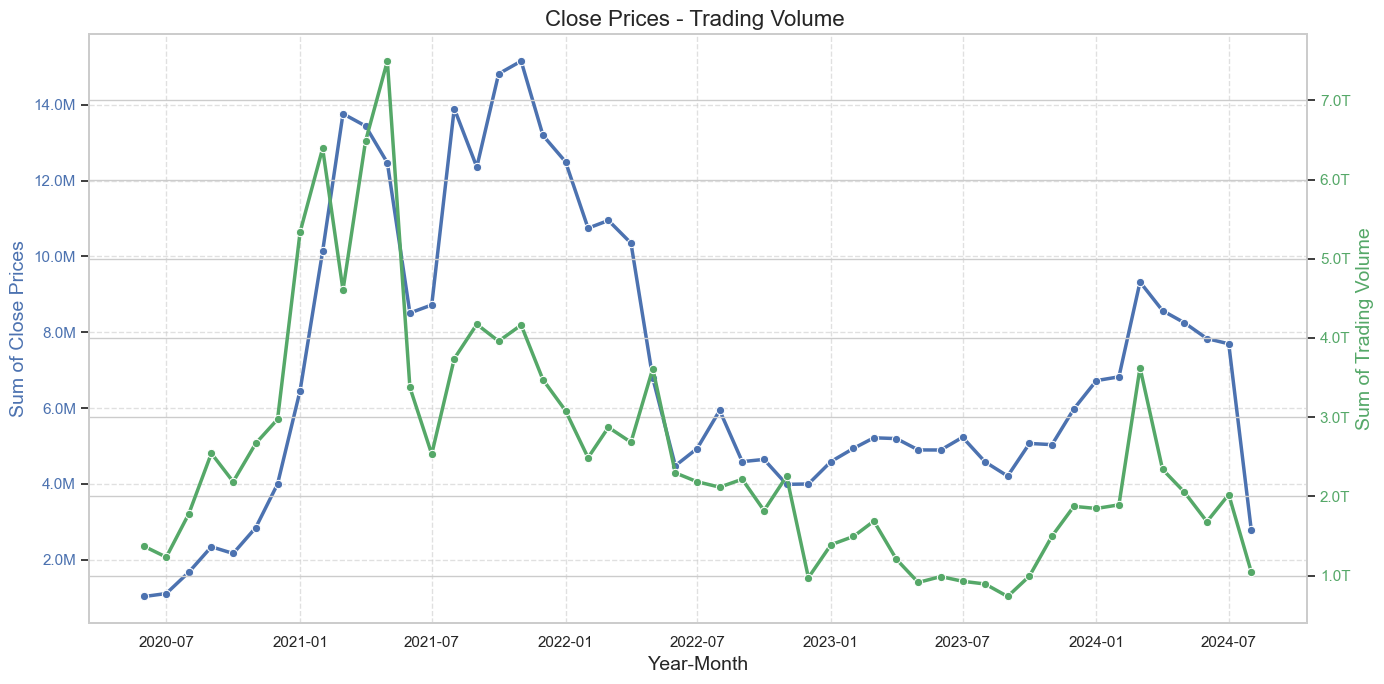

In [6]:
# Load the data
data = pd.read_csv(OHLCV_FILE_PATH)

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract the year and month from the 'date' column
data['year_month'] = data['date'].dt.to_period('M')

# Group by the 'year_month' and sum the 'close' prices and 'volume'
monthly_data_sum = data.groupby('year_month').agg({
    'close': 'sum',
    'volume': 'sum'
}).reset_index()

# Convert 'year_month' back to datetime for plotting
monthly_data_sum['year_month'] = monthly_data_sum['year_month'].dt.to_timestamp()

# Set up the plot style and size
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting the close prices on the left y-axis
sns.lineplot(x='year_month', y='close', data=monthly_data_sum, marker='o', color='b', linewidth=2.5, ax=ax1)
ax1.set_xlabel('Year-Month', fontsize=14)
ax1.set_ylabel('Sum of Close Prices', fontsize=14, color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.yaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter

# Creating a second y-axis for the trading volume
ax2 = ax1.twinx()
sns.lineplot(x='year_month', y='volume', data=monthly_data_sum, marker='o', color='g', linewidth=2.5, ax=ax2)
ax2.set_ylabel('Sum of Trading Volume', fontsize=14, color='g')
ax2.tick_params(axis='y', labelcolor='g')
ax2.yaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter

# Adding titles and improving the x-axis labels
plt.title('Close Prices - Trading Volume ', fontsize=16)
plt.xticks(rotation=45)

# Add a grid for better readability
ax1.grid(True, linestyle='--', alpha=0.6)

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()


Summary statistics for BTC:
                      date          open          high           low  \
count                 1534   1534.000000   1534.000000   1534.000000   
mean   2022-07-07 12:00:00  35474.786035  36262.243557  34629.809689   
min    2020-06-01 00:00:00   9048.460938   9162.183594   8975.525391   
25%    2021-06-19 06:00:00  21546.367188  21880.706543  20987.967285   
50%    2022-07-07 12:00:00  32539.872070  33883.109375  31219.741211   
75%    2023-07-25 18:00:00  47110.990234  48316.791016  46266.737305   
max    2024-08-12 00:00:00  73079.375000  73750.070312  71334.093750   
std                    NaN  16941.721648  17340.961922  16478.770801   

              close        volume  
count   1534.000000  1.534000e+03  
mean   35504.726334  3.151303e+10  
min     9045.390625  5.331173e+09  
25%    21594.381348  1.953023e+10  
50%    32635.937500  2.777932e+10  
75%    47122.381836  3.841646e+10  
max    73083.500000  3.509679e+11  
std    16937.008992  1.882129e+10  

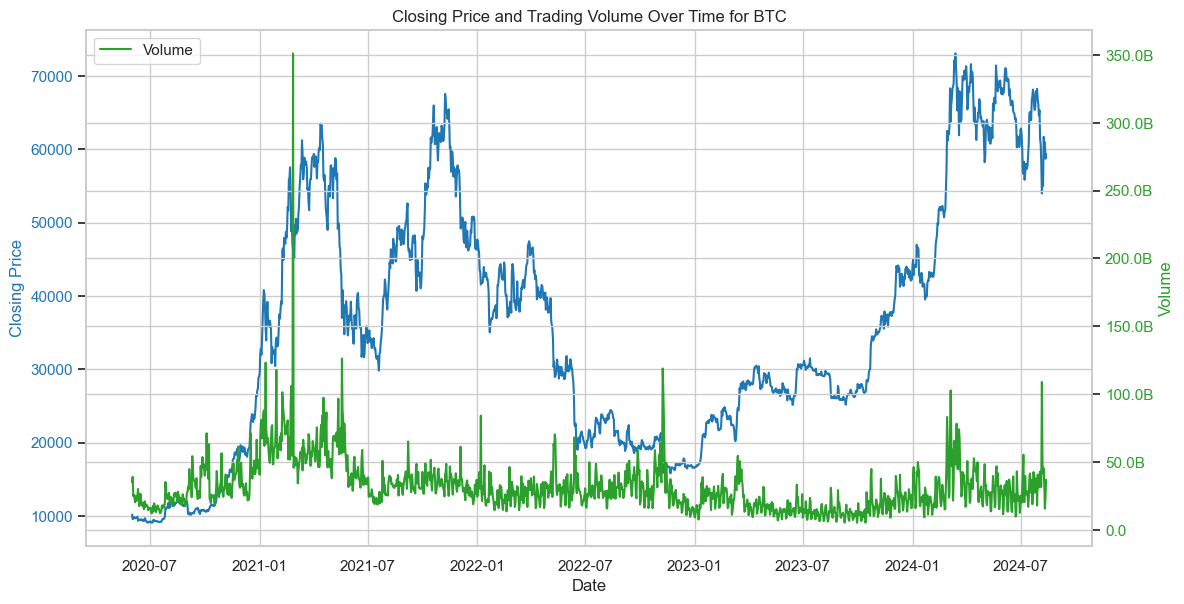

Summary statistics for ETH:
                      date         open         high          low  \
count                 1534  1534.000000  1534.000000  1534.000000   
mean   2022-07-07 12:00:00  2074.985047  2130.925431  2013.638157   
min    2020-06-01 00:00:00   222.914490   228.598282   219.472672   
25%    2021-06-19 06:00:00  1408.301361  1463.200775  1337.435669   
50%    2022-07-07 12:00:00  1872.507935  1908.191833  1845.784241   
75%    2023-07-25 18:00:00  2944.567871  3019.733887  2862.258179   
max    2024-08-12 00:00:00  4810.071289  4891.704590  4718.039062   
std                    NaN  1068.403865  1097.567792  1034.039103   

             close        volume  
count  1534.000000  1.534000e+03  
mean   2076.363137  1.611645e+10  
min     222.959793  2.081626e+09  
25%    1416.521332  8.876621e+09  
50%    1873.009705  1.406908e+10  
75%    2944.742004  2.023119e+10  
max    4812.087402  8.448291e+10  
std    1067.031840  1.035292e+10  


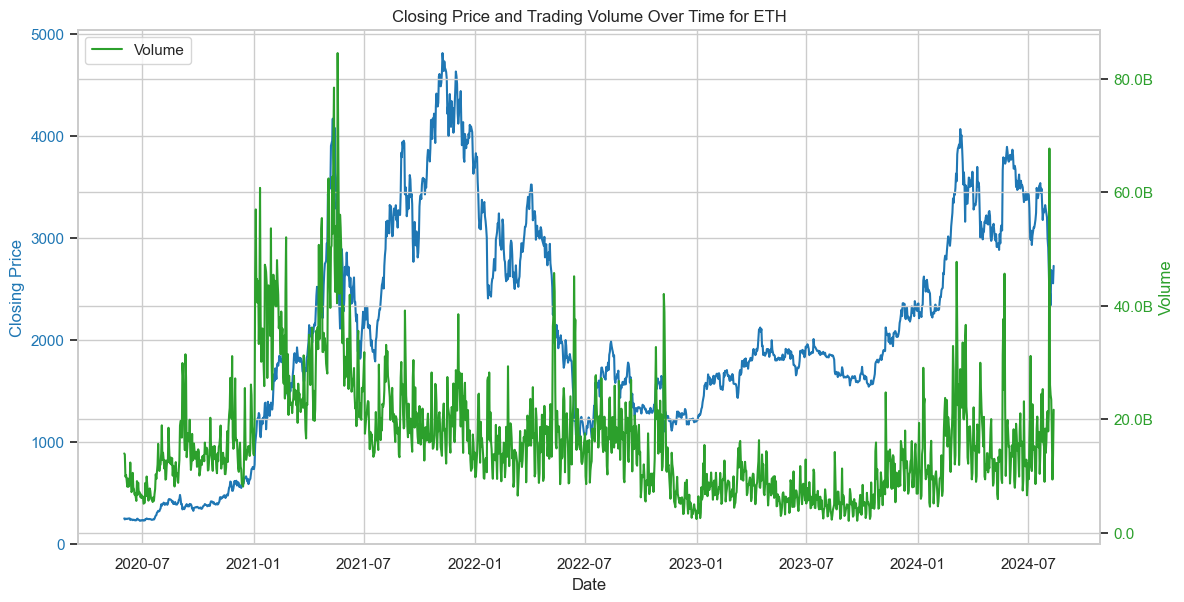

Summary statistics for SOL:
                      date         open         high          low  \
count                 1534  1534.000000  1534.000000  1534.000000   
mean   2022-07-07 12:00:00    60.892629    63.506808    58.294421   
min    2020-06-01 00:00:00     0.564669     0.587839     0.547287   
25%    2021-06-19 06:00:00    17.270924    18.345827    16.401849   
50%    2022-07-07 12:00:00    32.681189    33.822115    31.362824   
75%    2023-07-25 18:00:00   101.167532   104.629786    97.265766   
max    2024-08-12 00:00:00   258.781555   260.062103   246.122421   
std                    NaN    61.539776    63.914902    58.922177   

             close        volume  
count  1534.000000  1.534000e+03  
mean     60.970050  1.423599e+09  
min       0.564669  6.520200e+05  
25%      17.326035  2.529767e+08  
50%      32.684443  8.636392e+08  
75%     101.294241  2.112208e+09  
max     258.934326  1.706864e+10  
std      61.525156  1.713217e+09  


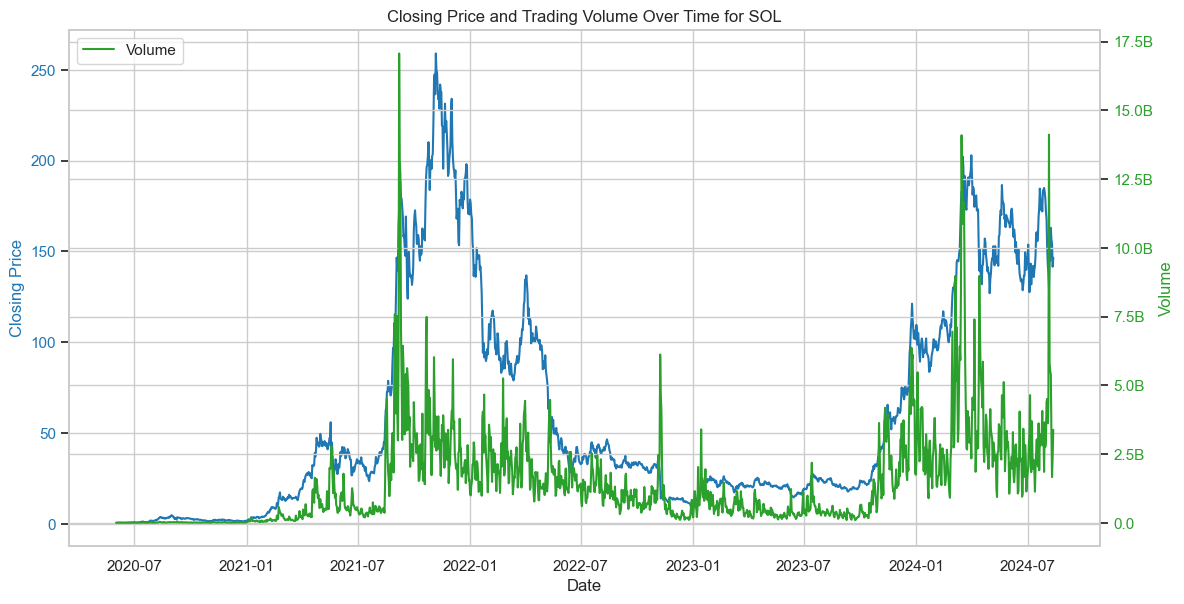

Summary statistics for ADA:
                      date         open         high          low  \
count                 1534  1534.000000  1534.000000  1534.000000   
mean   2022-07-07 12:00:00     0.682026     0.707862     0.654684   
min    2020-06-01 00:00:00     0.074244     0.079173     0.069770   
25%    2021-06-19 06:00:00     0.307459     0.314803     0.298616   
50%    2022-07-07 12:00:00     0.446538     0.455698     0.433917   
75%    2023-07-25 18:00:00     0.975764     1.027467     0.932501   
max    2024-08-12 00:00:00     2.966390     3.099186     2.907606   
std                    NaN     0.593250     0.619446     0.565303   

             close        volume  
count  1534.000000  1.534000e+03  
mean      0.682226  1.479493e+09  
min       0.075360  5.825736e+07  
25%       0.307466  3.212843e+08  
50%       0.446538  6.390660e+08  
75%       0.976004  1.636151e+09  
max       2.968239  1.914198e+10  
std       0.593255  2.146972e+09  


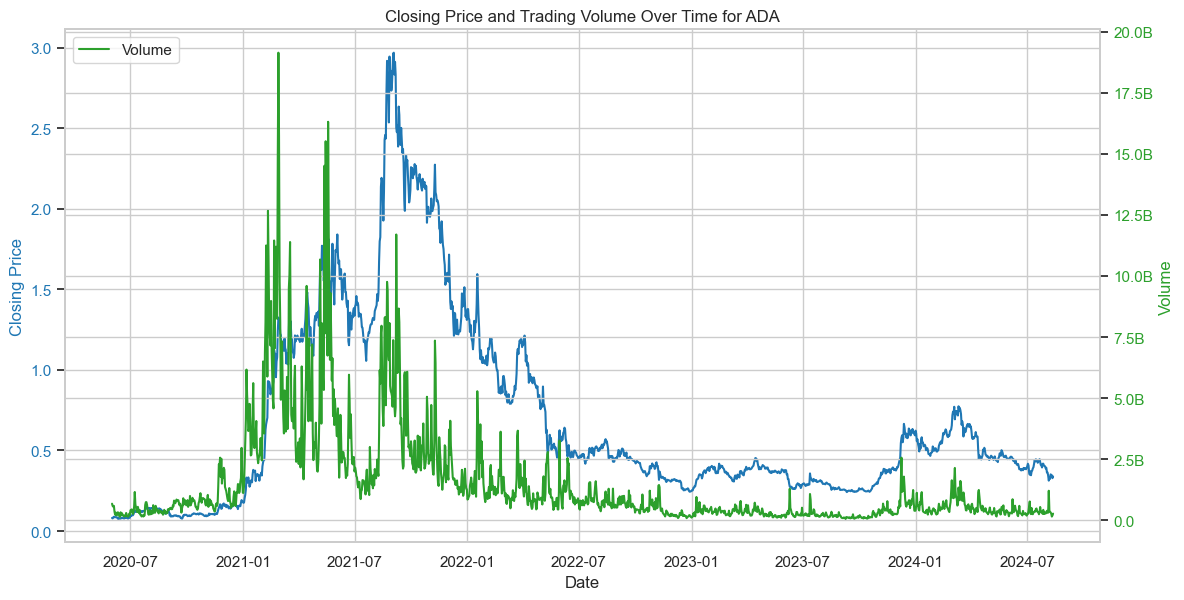

Summary statistics for BNB:
                      date         open         high          low  \
count                 1534  1534.000000  1534.000000  1534.000000   
mean   2022-07-07 12:00:00   307.841518   316.148797   298.943767   
min    2020-06-01 00:00:00    15.185254    15.511128    15.020651   
25%    2021-06-19 06:00:00   231.745590   237.237549   226.310062   
50%    2022-07-07 12:00:00   302.236298   308.952911   294.382767   
75%    2023-07-25 18:00:00   408.336372   419.706963   396.916588   
max    2024-08-12 00:00:00   710.460388   720.672607   692.994751   
std                    NaN   170.427562   175.037869   165.082152   

             close        volume  
count  1534.000000  1.534000e+03  
mean    308.131974  1.477317e+09  
min      15.185254  1.365992e+08  
25%     231.913357  5.054591e+08  
50%     302.272644  1.093633e+09  
75%     408.577904  1.921445e+09  
max     710.464050  1.798295e+10  
std     170.283132  1.461307e+09  


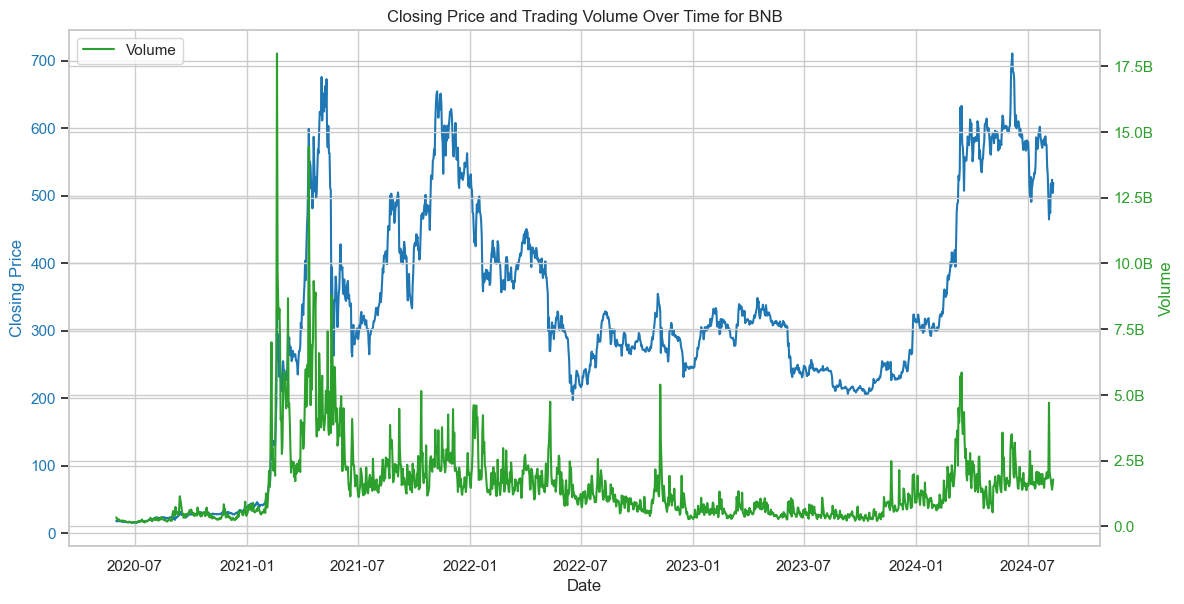

Summary statistics for XRP:
                      date         open         high          low  \
count                 1534  1534.000000  1534.000000  1534.000000   
mean   2022-07-07 12:00:00     0.571073     0.591220     0.549292   
min    2020-06-01 00:00:00     0.175750     0.178338     0.174234   
25%    2021-06-19 06:00:00     0.383759     0.393493     0.374210   
50%    2022-07-07 12:00:00     0.515186     0.525484     0.501198   
75%    2023-07-25 18:00:00     0.652964     0.676953     0.627273   
max    2024-08-12 00:00:00     1.837281     1.964997     1.658103   
std                    NaN     0.274847     0.291542     0.256885   

             close        volume  
count  1534.000000  1.534000e+03  
mean      0.571305  2.947930e+09  
min       0.175870  2.253910e+08  
25%       0.383760  1.060069e+09  
50%       0.515418  1.653136e+09  
75%       0.653804  3.068769e+09  
max       1.839236  3.695518e+10  
std       0.274690  3.886650e+09  


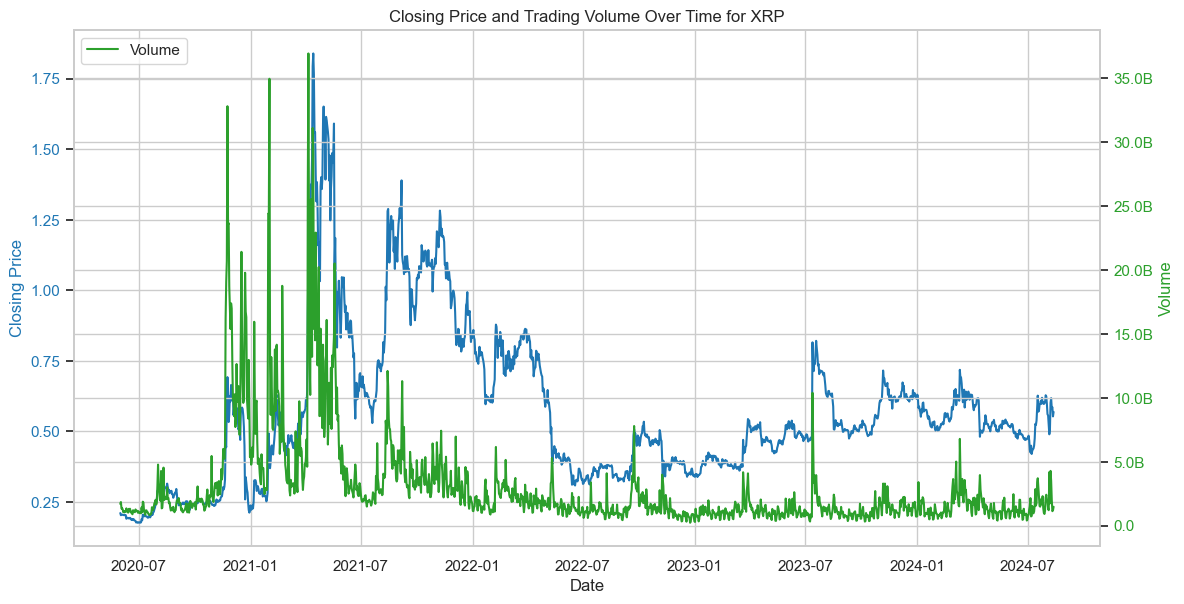

Summary statistics for OCEAN:
                      date         open         high          low  \
count                 1534  1534.000000  1534.000000  1534.000000   
mean   2022-07-07 12:00:00     0.525473     0.553628     0.498545   
min    2020-06-01 00:00:00     0.067598     0.070651     0.066309   
25%    2021-06-19 06:00:00     0.316461     0.328255     0.307127   
50%    2022-07-07 12:00:00     0.434371     0.453455     0.415179   
75%    2023-07-25 18:00:00     0.669955     0.715819     0.623290   
max    2024-08-12 00:00:00     1.818558     1.941328     1.719507   
std                    NaN     0.335285     0.356576     0.315468   

             close        volume  
count  1534.000000  1.534000e+03  
mean      0.525674  3.663157e+07  
min       0.067598  6.259840e+05  
25%       0.316864  1.425049e+07  
50%       0.434410  2.539716e+07  
75%       0.669936  4.544641e+07  
max       1.817588  5.572306e+08  
std       0.335228  4.235790e+07  


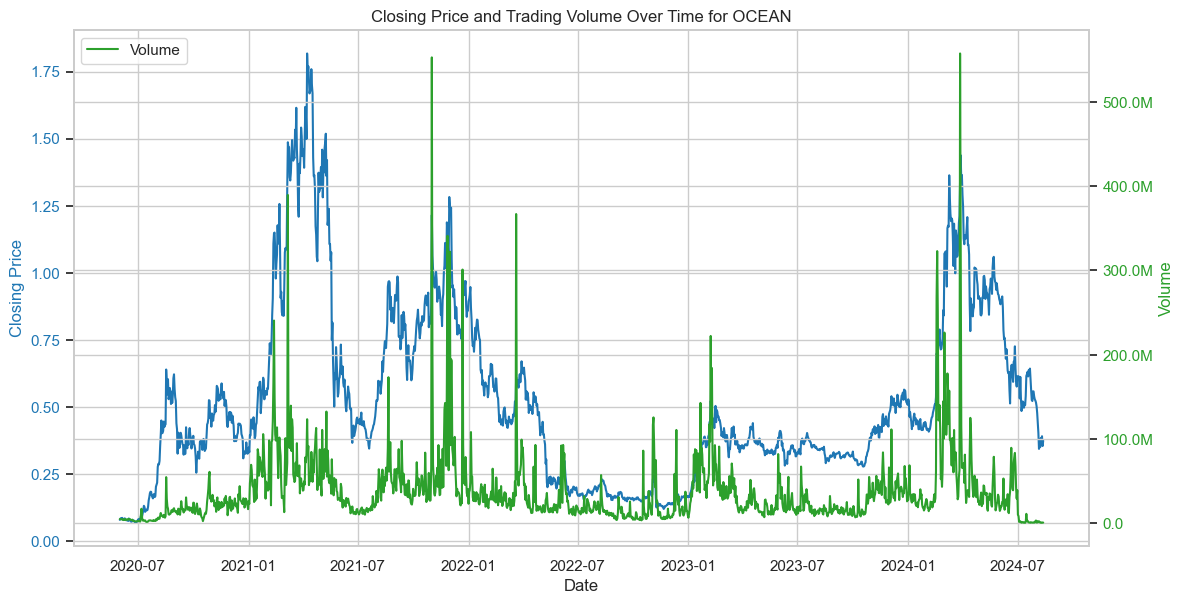

Summary statistics for NMR:
                      date         open         high          low  \
count                 1534  1534.000000  1534.000000  1534.000000   
mean   2022-07-07 12:00:00    25.883902    27.301867    24.823013   
min    2020-06-01 00:00:00     7.784979     8.116864     7.199391   
25%    2021-06-19 06:00:00    15.137353    15.698964    14.714276   
50%    2022-07-07 12:00:00    23.240904    24.146797    22.305967   
75%    2023-07-25 18:00:00    32.462271    34.556371    31.155035   
max    2024-08-12 00:00:00    89.891556    96.137466    73.688042   
std                    NaN    13.116280    14.278220    12.270710   

             close        volume  
count  1534.000000  1.534000e+03  
mean     25.874461  1.765428e+07  
min       7.789050  2.647820e+05  
25%      15.120450  4.694778e+06  
50%      23.238299  9.231895e+06  
75%      32.464223  1.918732e+07  
max      90.790596  6.295865e+08  
std      13.119370  3.456724e+07  


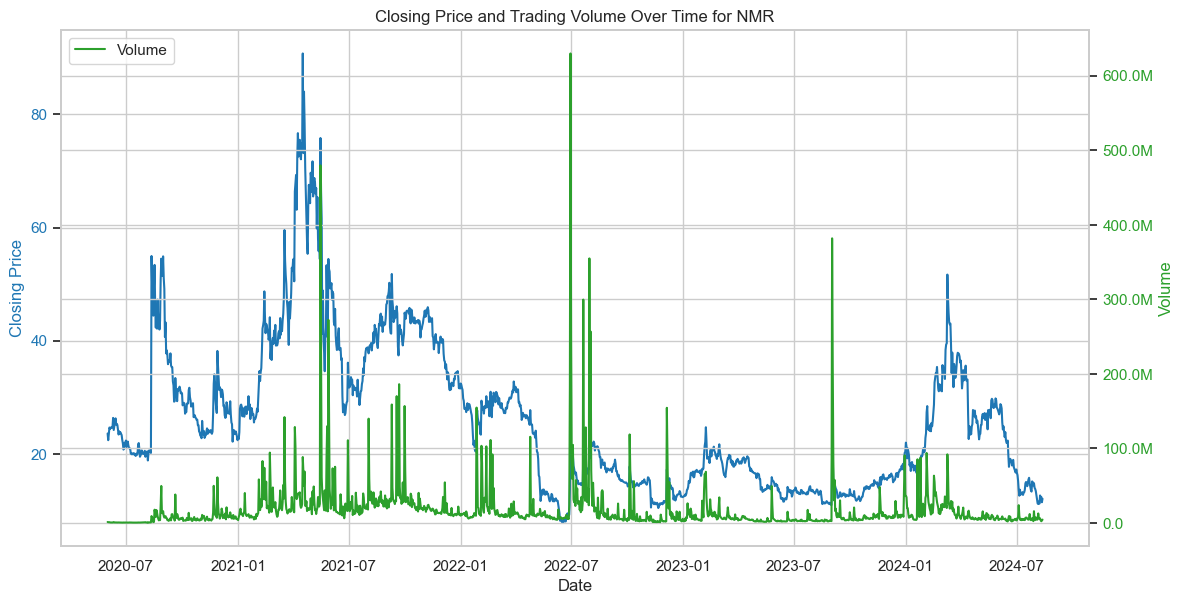

Summary statistics for FET:
                      date         open         high          low  \
count                 1534  1534.000000  1534.000000  1534.000000   
mean   2022-07-07 12:00:00     0.483606     0.512065     0.458302   
min    2020-06-01 00:00:00     0.022329     0.024353     0.022175   
25%    2021-06-19 06:00:00     0.094379     0.100201     0.090158   
50%    2022-07-07 12:00:00     0.287555     0.303130     0.268034   
75%    2023-07-25 18:00:00     0.569340     0.609150     0.546999   
max    2024-08-12 00:00:00     3.263083     3.474265     3.094668   
std                    NaN     0.590676     0.623910     0.559307   

             close        volume  
count  1534.000000  1.534000e+03  
mean      0.484164  6.960117e+07  
min       0.023014  1.821266e+06  
25%       0.094518  1.406052e+07  
50%       0.287726  3.256001e+07  
75%       0.570097  7.782668e+07  
max       3.263083  1.109447e+09  
std       0.590662  1.092185e+08  


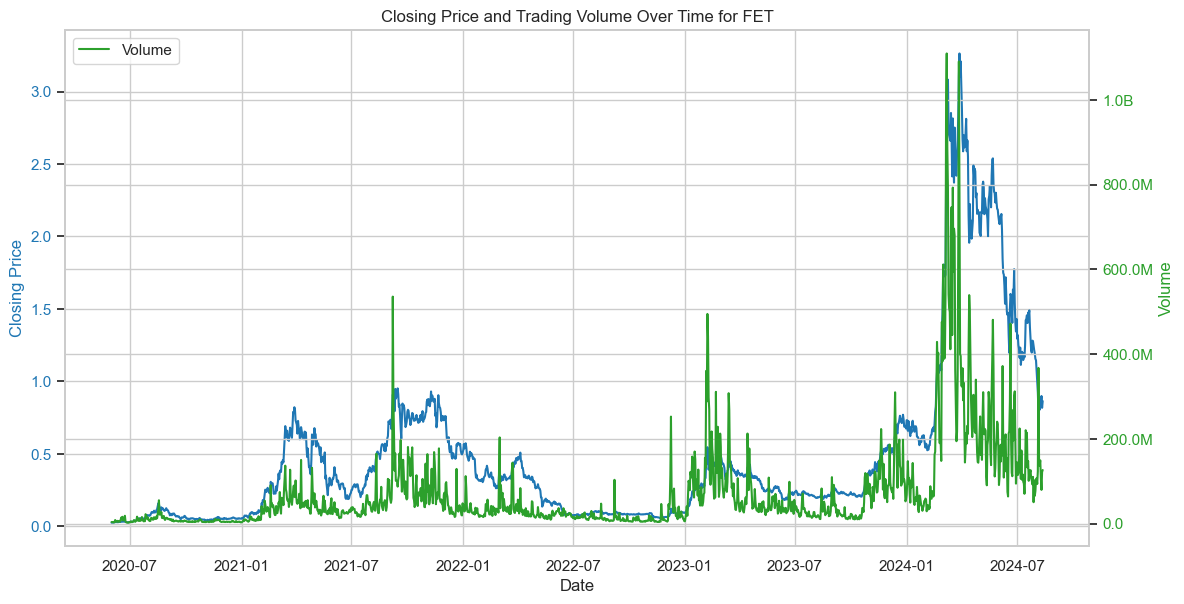

: 

In [7]:
def perform_eda(df, symbol):
    df_symbol = df[df['symbol'] == symbol]
    
    # Summary statistics
    print(f"Summary statistics for {symbol}:")
    print(df_symbol.describe())
    
    # Plot closing price and volume on the same graph
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Closing Price', color=color)
    ax1.plot(df_symbol['date'], df_symbol['close'], color=color, label='Closing Price')
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()  # Instantiate a second y-axis that shares the same x-axis
    color = 'tab:green'
    ax2.set_ylabel('Volume', color=color)
    ax2.plot(df_symbol['date'], df_symbol['volume'], color=color, label='Volume')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.yaxis.set_major_formatter(FuncFormatter(human_readable_format))  # Apply the formatter

    fig.tight_layout()  # Adjust the layout to make room for the y-labels
    plt.title(f'Closing Price and Trading Volume Over Time for {symbol}')
    plt.legend(loc='upper left')
    plt.show()


# Perform EDA for a sample of symbols 
sample_data = data[data['symbol'].isin(SAMPLE_SYMBOLS)]

for symbol in SAMPLE_SYMBOLS:
    df = data[data['symbol'] == symbol]
    perform_eda(df, symbol)
